In [1]:
import sparsetools as sp
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from copy import deepcopy as cp

Let us synthesize the Stokes spectra in 1D NLTE PRD of a modified (adding LOS velocity and magnetic field vector) FALC (ADD REFERENCE!!) model.

In [2]:
!ln -vfs input_syn.cfg input.cfg

'input.cfg' -> 'input_syn.cfg'


In [3]:
!ln -vfs keyword_prd.input keyword.input

'keyword.input' -> 'keyword_prd.input'


In [4]:
!mpirun -n 2 ./STiC.x


   SSSSSSSSSSSSSSS TTTTTTTTTTTTTTTTTTTTTTT  iiii         CCCCCCCCCCCCC
 SS:::::::::::::::ST:::::::::::::::::::::T i::::i     CCC::::::::::::C
S:::::SSSSSS::::::ST:::::::::::::::::::::T  iiii    CC:::::::::::::::C
S:::::S     SSSSSSST:::::TT:::::::TT:::::T         C:::::CCCCCCCC::::C
S:::::S            TTTTTT  T:::::T  TTTTTTiiiiiii C:::::C       CCCCCC
S:::::S                    T:::::T        i:::::iC:::::C              
 S::::SSSS                 T:::::T         i::::iC:::::C              
  SS::::::SSSSS            T:::::T         i::::iC:::::C              
    SSS::::::::SS          T:::::T         i::::iC:::::C              
       SSSSSS::::S         T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::i C:::::C       CCCCCC
SSSSSSS     S:::::S      TT:::::::TT      i::::::i C:::::CCCCCCCC::::C
S::::::SSSSSS:::::S      T:::::::::T      i::::::i  CC:::::::::::::::C
S::::

We can use the "profile" method of the STiC python module to read the synthetic profiles:

In [5]:
obs = sp.profile("./synthetic_cycle0.nc")

profile::setsize: nx=1, ny=1, nw=260, ns=4, nt=1
['profiles' 'wav']
profile::read: [profiles][wav]


In [6]:
def plot_profile(llp, t=0, y=0, x=0, s=0, kwargs=[], plkwargs={}):
    #
    #
    # Check inputs
    if (len(kwargs)!=len(llp)):
        ikwargs = [{},] * len(llp)
    else:
        ikwargs = cp(kwargs)
    #
    #
    pl.figure(**plkwargs)
    # Loop through profiles and plot kwargs
    for i,j in zip(llp, ikwargs):
        ww = np.where(i.weights[:,s]<2)
        pl.plot(ww[0], i.dat[t,y,x,ww[0],s], **j)
    #
    #
    # End plot:
    for i in ikwargs:
        if ("label" in i):
            pl.legend()
    pl.tight_layout()

In [7]:
def plot_model(llm, t=0, y=0, x=0, mpars=["temp", "vlos", "vturb", "Bln", "Bho", "azi"], kwargs=[], plkwargs={}):
    #
    #
    mnames = {"temp":"T", "vlos":r"v$_{\rm LOS}$", "vturb":r"v$_{\rm turb}$", "Bln":r"B$_{\parallel}$", "Bho":r"B$_{\perp}$", "azi":r"B$_{\phi}$"}
    munits = {"temp":"kK", "vlos":"km/s", "vturb":"km/s", "Bln":"G", "Bho":"G", "azi":"rd"}
    mfactors = {"temp":1.e-3, "vlos":1.e-5, "vturb":1.e-5, "Bln":1, "Bho":1, "azi":1}
    #
    # Check inputs
    if (len(kwargs)!=len(llm)):
        ikwargs = [{},] * len(llm)
    else:
        ikwargs = cp(kwargs)
    #
    #
    npars = len(mpars)
    ncols = np.ceil(np.sqrt(npars)).astype("i2")
    nrows = np.ceil(npars/ncols).astype("i2")
    fg, ax = pl.subplots(ncols=ncols, nrows=nrows, sharex=True, **plkwargs)
    # Loop through model parameters and models and plot kwargs
    for lcp, lip in enumerate(mpars):
        for i,j in zip(llm, ikwargs):
            ax.flat[lcp].plot(i.ltau[t,y,x,:], getattr(i, lip)[t,y,x,:] * mfactors[lip], **j)
    #
    #
    # End plot:
    for lcp, lip in enumerate(mpars):
        ax.flat[lcp].set_ylabel(r"%s [%s]" % (mnames[lip], munits[lip],))
    for i in ikwargs:
        if ("label" in i):
            pl.legend()
            break
    pl.tight_layout()

Let us assume that only data with wavelengths larger than 5000 angstrom have polarimetry and that we have achieved a SNR of 600:

In [8]:
# Add some noise:
snr = 600.
nobs = cp(obs)
rng = np.random.default_rng(seed=12345)
nobs.dat += rng.normal(size=nobs.dat.size).reshape(*nobs.dat.shape) / snr
ww = np.where(nobs.wav < 5000.)
nobs.weights = nobs.weights * 0. + 1./snr
nobs.weights[ww[0],1:] = 1.e32
nobs.dat[:,:,:,ww[0],1:] *= 0

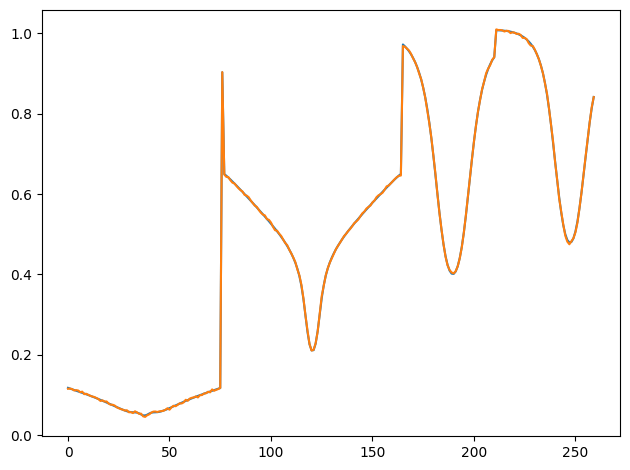

In [9]:
plot_profile([obs,nobs],s=0)

Write the modified synthetic spectra to use for the inversions:

In [10]:
nobs.write("./observed.nc")

profile::write: saving data [./observed.nc]


For the stokes inversion we need to provide an initial guess for the model atmosphere. Let us generate a 'reasonable' model:

In [11]:
# Init the input model, all quantities in CGS units!
# First create a tau scale
taumin = -7.8
taumax= 1.0
dtau = 0.1
ntau = int((taumax-taumin)/dtau) + 1
tau = np.arange(ntau, dtype='float64')/(ntau-1.0) * (taumax-taumin) + taumin
# Now create a smooth temperature profile
temp = np.interp(tau, np.asarray([-8.0, -6.0, -4.0, -2.0 , 0.8]), np.asarray([70000., 8000., 4000., 4800., 7000.]))
# Fill in the model
m = sp.model(nx=1, ny=1, nt=1, ndep=ntau)
m.ltau[0,0,0,:] = tau
m.temp[0,0,0,:] = temp
# The inversion only needs to know the gas pressure at the upper boundary. FALC has Pgas[top] ~ 0.3, but
# this value is for quiet-Sun. Active regions can have up to Pgas[top] = 10.
m.pgas[0,0,0,:] = 1.0
# Fill in initial B field and velovity (optional)
m.vturb[0,0,0,:] = 1.e5
m.vlos[0,0,0,:] = 0.5e5 # cm/s
m.Bln[0,0,0,:] = 300.
m.Bho[0,0,0,:] = 650.
m.azi[0,0,0,:] = 100. * 3.14159 / 180.
# Write to HD
m.write('modelin.nc')


model::setSize: nx = 1, ny = 1, ndep = 89, nt = 1
model::write: modelin.nc -> nx=1, ny=1, ndep=89, nt=1


For reference, let us start with the inversion in LTE:

In [12]:
!ln -vfs input_lte.cfg input.cfg

'input.cfg' -> 'input_lte.cfg'


In [13]:
!mpirun -n 2 ./STiC.x


   SSSSSSSSSSSSSSS TTTTTTTTTTTTTTTTTTTTTTT  iiii         CCCCCCCCCCCCC
 SS:::::::::::::::ST:::::::::::::::::::::T i::::i     CCC::::::::::::C
S:::::SSSSSS::::::ST:::::::::::::::::::::T  iiii    CC:::::::::::::::C
S:::::S     SSSSSSST:::::TT:::::::TT:::::T         C:::::CCCCCCCC::::C
S:::::S            TTTTTT  T:::::T  TTTTTTiiiiiii C:::::C       CCCCCC
S:::::S                    T:::::T        i:::::iC:::::C              
 S::::SSSS                 T:::::T         i::::iC:::::C              
  SS::::::SSSSS            T:::::T         i::::iC:::::C              
    SSS::::::::SS          T:::::T         i::::iC:::::C              
       SSSSSS::::S         T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::i C:::::C       CCCCCC
SSSSSSS     S:::::S      TT:::::::TT      i::::::i C:::::CCCCCCCC::::C
S::::::SSSSSS:::::S      T:::::::::T      i::::::i  CC:::::::::::::::C
S::::

Now, let us consider the case of a NLTE inversion but in CRD:

In [14]:
!ln -vfs input_crd.cfg input.cfg

'input.cfg' -> 'input_crd.cfg'


In [15]:
!ln -vfs keyword_crd.input keyword.input

'keyword.input' -> 'keyword_crd.input'


In [16]:
!mpirun -n 2 ./STiC.x


   SSSSSSSSSSSSSSS TTTTTTTTTTTTTTTTTTTTTTT  iiii         CCCCCCCCCCCCC
 SS:::::::::::::::ST:::::::::::::::::::::T i::::i     CCC::::::::::::C
S:::::SSSSSS::::::ST:::::::::::::::::::::T  iiii    CC:::::::::::::::C
S:::::S     SSSSSSST:::::TT:::::::TT:::::T         C:::::CCCCCCCC::::C
S:::::S            TTTTTT  T:::::T  TTTTTTiiiiiii C:::::C       CCCCCC
S:::::S                    T:::::T        i:::::iC:::::C              
 S::::SSSS                 T:::::T         i::::iC:::::C              
  SS::::::SSSSS            T:::::T         i::::iC:::::C              
    SSS::::::::SS          T:::::T         i::::iC:::::C              
       SSSSSS::::S         T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::i C:::::C       CCCCCC
SSSSSSS     S:::::S      TT:::::::TT      i::::::i C:::::CCCCCCCC::::C
S::::::SSSSSS:::::S      T:::::::::T      i::::::i  CC:::::::::::::::C
S::::

Finally, let us consider the inversion of NLTE with PRD in a 1D approach, which is the model with the most physics that STiC can handle in the inversion

In [17]:
!ln -vfs input_prd.cfg input.cfg

'input.cfg' -> 'input_prd.cfg'


In [18]:
!ln -vfs keyword_prd.input keyword.input

'keyword.input' -> 'keyword_prd.input'


In [19]:
!mpirun -n 2 ./STiC.x


   SSSSSSSSSSSSSSS TTTTTTTTTTTTTTTTTTTTTTT  iiii         CCCCCCCCCCCCC
 SS:::::::::::::::ST:::::::::::::::::::::T i::::i     CCC::::::::::::C
S:::::SSSSSS::::::ST:::::::::::::::::::::T  iiii    CC:::::::::::::::C
S:::::S     SSSSSSST:::::TT:::::::TT:::::T         C:::::CCCCCCCC::::C
S:::::S            TTTTTT  T:::::T  TTTTTTiiiiiii C:::::C       CCCCCC
S:::::S                    T:::::T        i:::::iC:::::C              
 S::::SSSS                 T:::::T         i::::iC:::::C              
  SS::::::SSSSS            T:::::T         i::::iC:::::C              
    SSS::::::::SS          T:::::T         i::::iC:::::C              
       SSSSSS::::S         T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::i C:::::C       CCCCCC
SSSSSSS     S:::::S      TT:::::::TT      i::::::i C:::::CCCCCCCC::::C
S::::::SSSSSS:::::S      T:::::::::T      i::::::i  CC:::::::::::::::C
S::::

In [20]:
nlteprd_prof = sp.profile("./synthetic_cycle1_prd.nc")
nltecrd_prof = sp.profile("./synthetic_cycle1_crd.nc")
lte_prof = sp.profile("./synthetic_cycle1_lte.nc")


profile::setsize: nx=1, ny=1, nw=260, ns=4, nt=1
['profiles' 'wav' 'weights']
profile::read: [profiles][wav][weights]
profile::setsize: nx=1, ny=1, nw=260, ns=4, nt=1
['profiles' 'wav' 'weights']
profile::read: [profiles][wav][weights]
profile::setsize: nx=1, ny=1, nw=260, ns=4, nt=1
['profiles' 'wav' 'weights']
profile::read: [profiles][wav][weights]


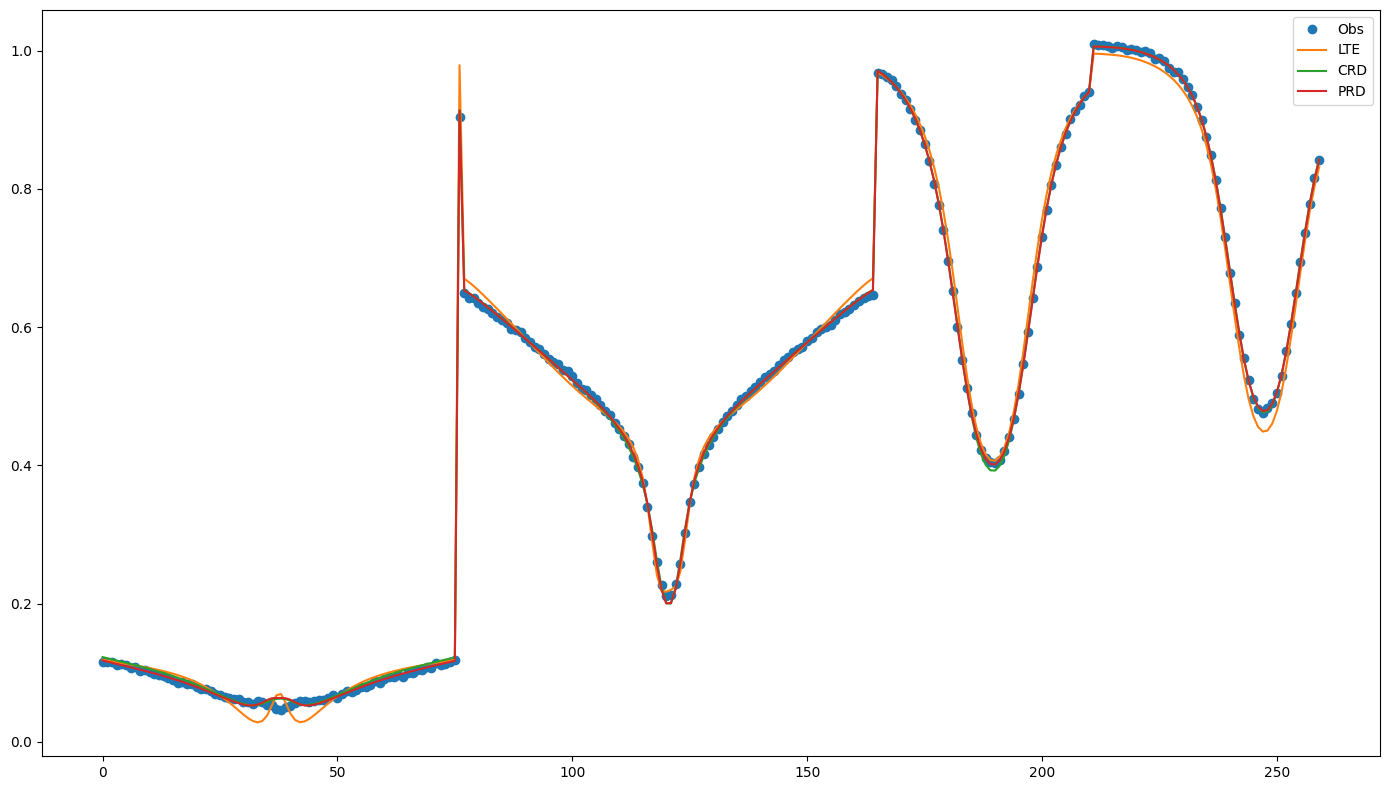

In [21]:
plot_profile([nobs,lte_prof,nltecrd_prof,nlteprd_prof]
             , kwargs=[{"label":"Obs","ls":"none","marker":"o"}, {"label":"LTE"}, {"label":"CRD"}, {"label":"PRD"},]
             , plkwargs={"figsize":(14,8)})

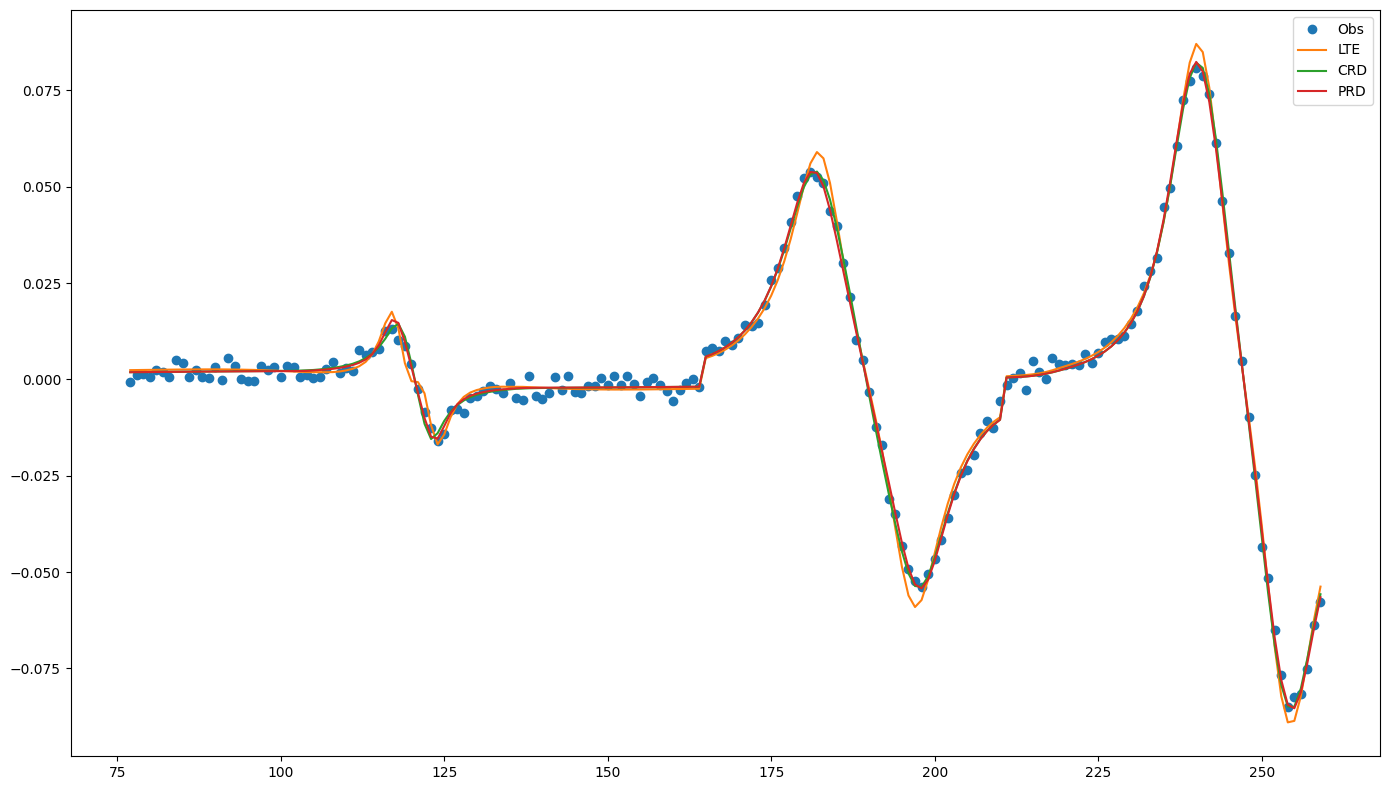

In [22]:
plot_profile([nobs,lte_prof,nltecrd_prof,nlteprd_prof]
             , kwargs=[{"label":"Obs","ls":"none","marker":"o"}, {"label":"LTE"}, {"label":"CRD"}, {"label":"PRD"},]
             , plkwargs={"figsize":(14,8)},s=3)

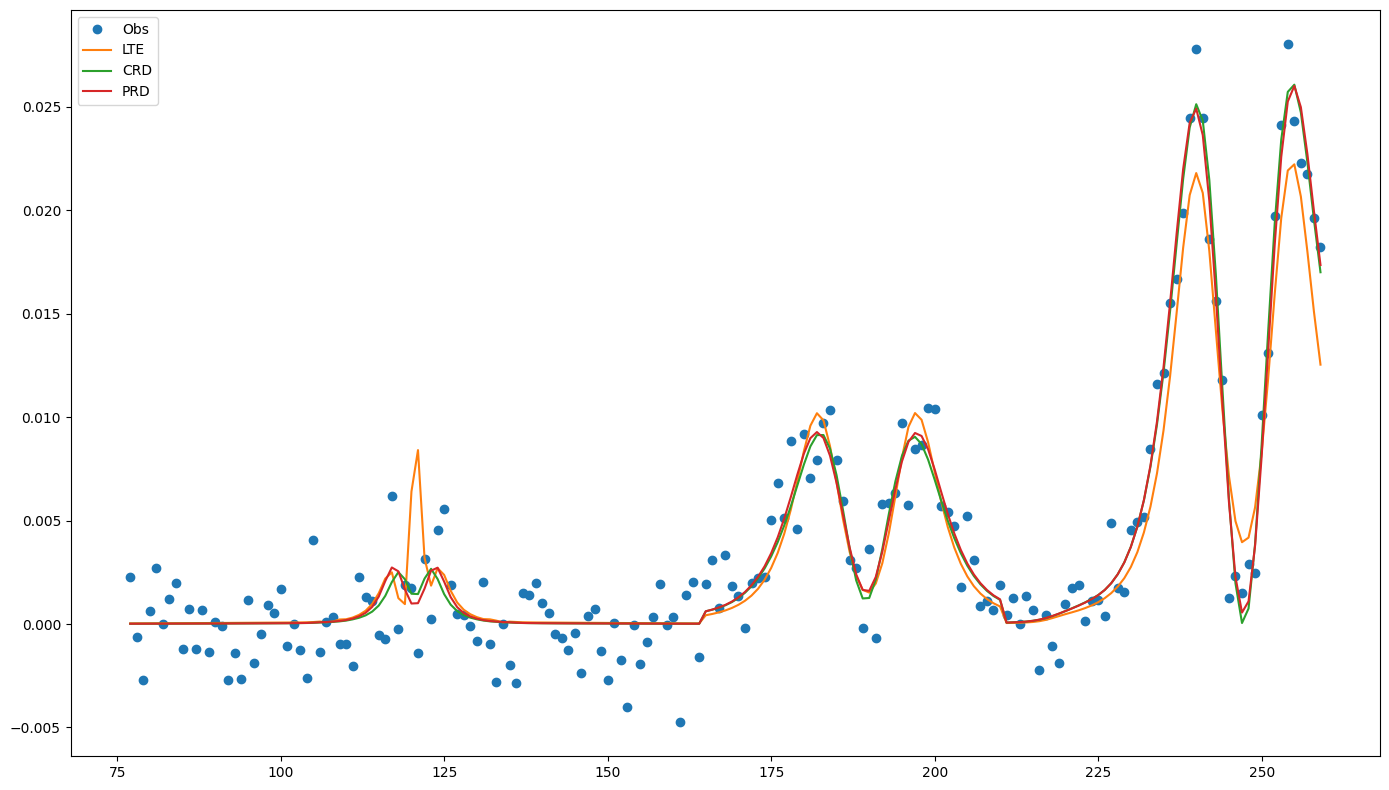

In [23]:
plot_profile([nobs,lte_prof,nltecrd_prof,nlteprd_prof]
             , kwargs=[{"label":"Obs","ls":"none","marker":"o"}, {"label":"LTE"}, {"label":"CRD"}, {"label":"PRD"},]
             , plkwargs={"figsize":(14,8)},s=1)

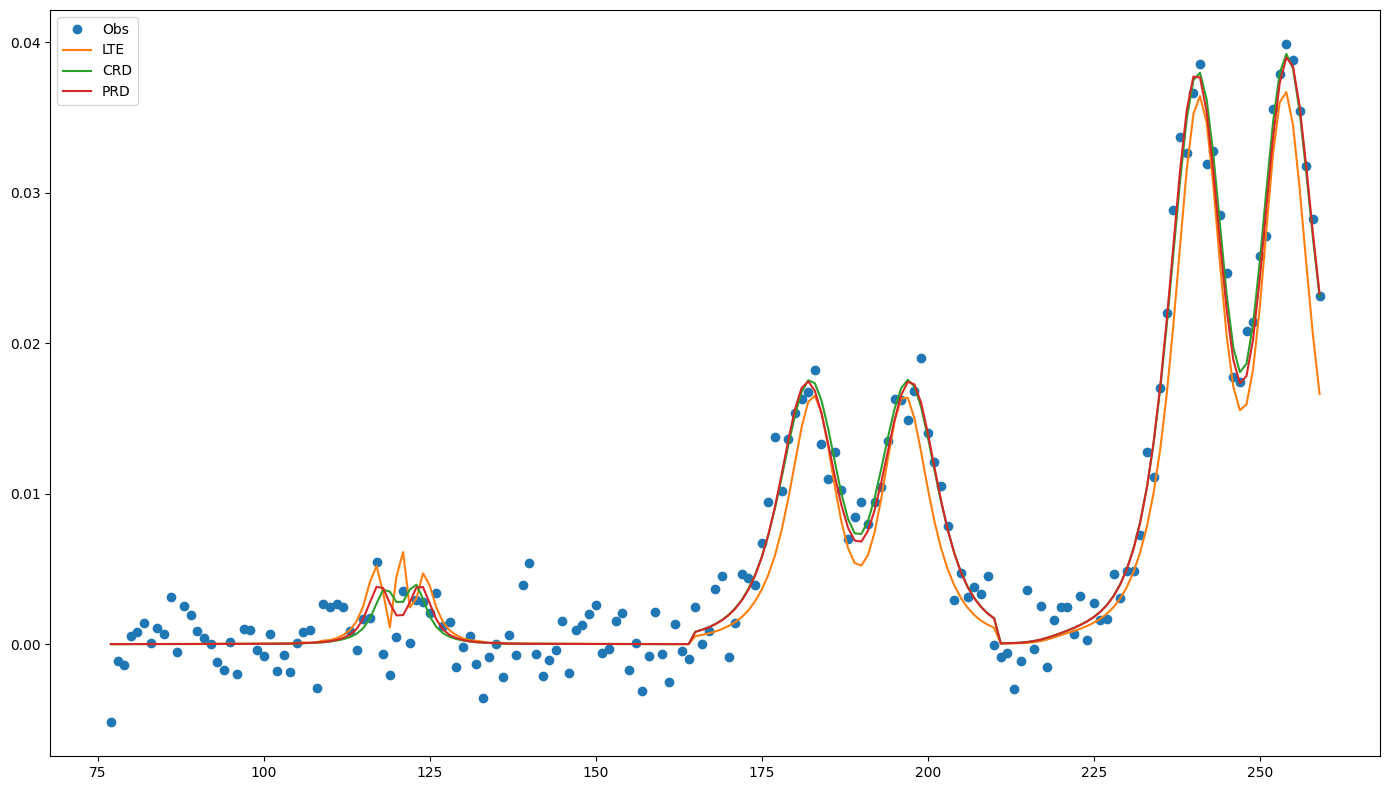

In [24]:
plot_profile([nobs,lte_prof,nltecrd_prof,nlteprd_prof]
             , kwargs=[{"label":"Obs","ls":"none","marker":"o"}, {"label":"LTE"}, {"label":"CRD"}, {"label":"PRD"},]
             , plkwargs={"figsize":(14,8)},s=2)

We can now compare the models we get in the various inversions to the reference one:

In [25]:
m_ref = sp.model("./infalc_model.nc")
m_lte = sp.model("./atmosout_cycle1_lte.nc")
m_crd = sp.model("./atmosout_cycle1_crd.nc")
m_prd = sp.model("./atmosout_cycle1_prd.nc")

model::read: atmos type -> depth-stratified
model::read: nx=1, ny=1, ndep=82, nt=1
model::setSize: nx = 1, ny = 1, ndep = 82, nt = 1
model::read: atmos type -> depth-stratified
model::read: nx=1, ny=1, ndep=89, nt=1
model::setSize: nx = 1, ny = 1, ndep = 89, nt = 1
model::read: atmos type -> depth-stratified
model::read: nx=1, ny=1, ndep=89, nt=1
model::setSize: nx = 1, ny = 1, ndep = 89, nt = 1
model::read: atmos type -> depth-stratified
model::read: nx=1, ny=1, ndep=89, nt=1
model::setSize: nx = 1, ny = 1, ndep = 89, nt = 1


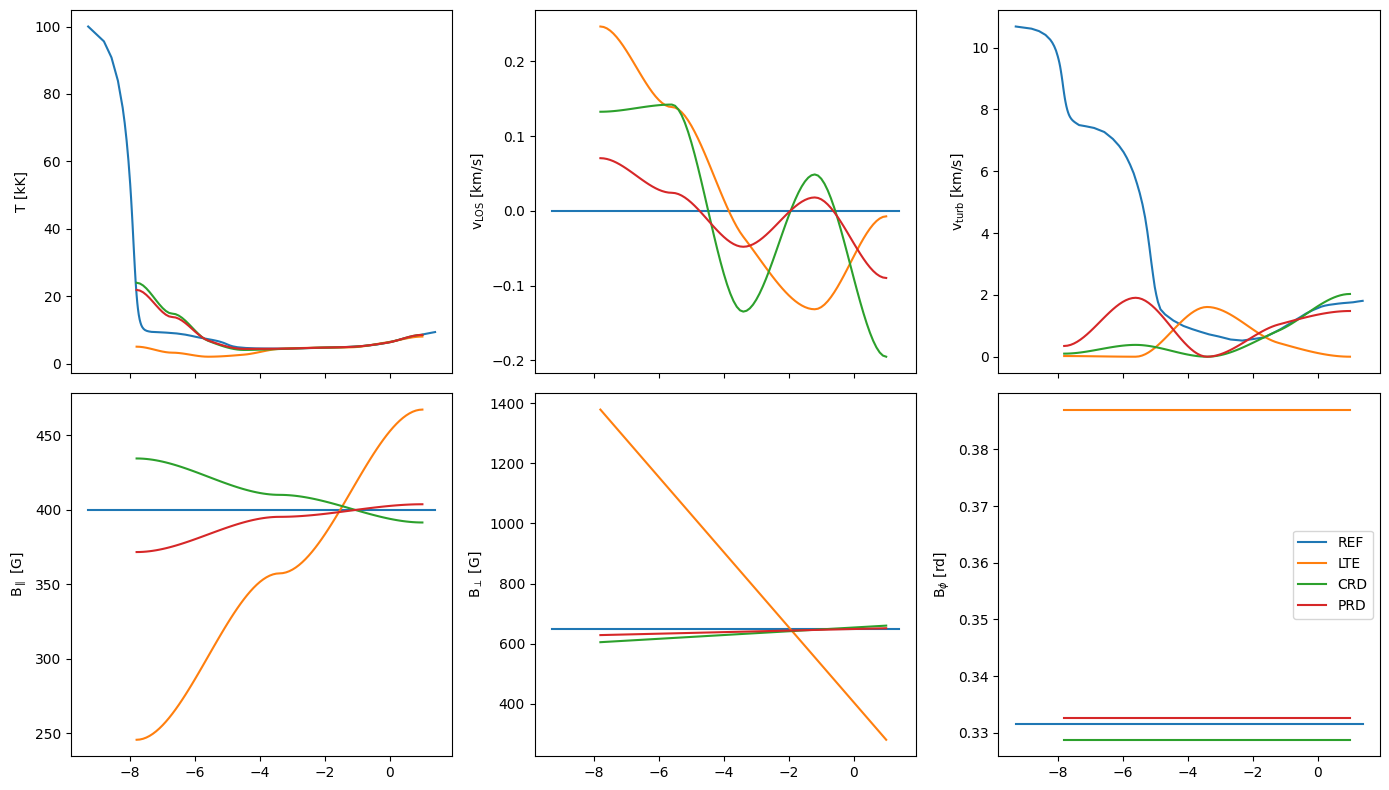

In [26]:
plot_model([m_ref, m_lte,m_crd, m_prd]
           , kwargs=[{"label":"REF"},{"label":"LTE"},{"label":"CRD"},{"label":"PRD"}]
           , plkwargs={"figsize":(14,8)})

However, the data we have used for the inversion does not necessarily probe the whole atmosphere we have included in the atmosphere model we feed the inversion with. One possibility to address this issue is to use the response functions (REFERENCES!!!), which can be calculated using STiC:

In [27]:
!ln -vfs input_lte_rf.cfg input.cfg

'input.cfg' -> 'input_lte_rf.cfg'


In [28]:
!mpirun -n 2 ./STiC.x


   SSSSSSSSSSSSSSS TTTTTTTTTTTTTTTTTTTTTTT  iiii         CCCCCCCCCCCCC
 SS:::::::::::::::ST:::::::::::::::::::::T i::::i     CCC::::::::::::C
S:::::SSSSSS::::::ST:::::::::::::::::::::T  iiii    CC:::::::::::::::C
S:::::S     SSSSSSST:::::TT:::::::TT:::::T         C:::::CCCCCCCC::::C
S:::::S            TTTTTT  T:::::T  TTTTTTiiiiiii C:::::C       CCCCCC
S:::::S                    T:::::T        i:::::iC:::::C              
 S::::SSSS                 T:::::T         i::::iC:::::C              
  SS::::::SSSSS            T:::::T         i::::iC:::::C              
    SSS::::::::SS          T:::::T         i::::iC:::::C              
       SSSSSS::::S         T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::i C:::::C       CCCCCC
SSSSSSS     S:::::S      TT:::::::TT      i::::::i C:::::CCCCCCCC::::C
S::::::SSSSSS:::::S      T:::::::::T      i::::::i  CC:::::::::::::::C
S::::

In [29]:
!ln -vfs input_crd_rf.cfg input.cfg

'input.cfg' -> 'input_crd_rf.cfg'


In [30]:
!ln -vfs keyword_crd.input keyword.input

'keyword.input' -> 'keyword_crd.input'


In [31]:
!mpirun -n 2 ./STiC.x


   SSSSSSSSSSSSSSS TTTTTTTTTTTTTTTTTTTTTTT  iiii         CCCCCCCCCCCCC
 SS:::::::::::::::ST:::::::::::::::::::::T i::::i     CCC::::::::::::C
S:::::SSSSSS::::::ST:::::::::::::::::::::T  iiii    CC:::::::::::::::C
S:::::S     SSSSSSST:::::TT:::::::TT:::::T         C:::::CCCCCCCC::::C
S:::::S            TTTTTT  T:::::T  TTTTTTiiiiiii C:::::C       CCCCCC
S:::::S                    T:::::T        i:::::iC:::::C              
 S::::SSSS                 T:::::T         i::::iC:::::C              
  SS::::::SSSSS            T:::::T         i::::iC:::::C              
    SSS::::::::SS          T:::::T         i::::iC:::::C              
       SSSSSS::::S         T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::i C:::::C       CCCCCC
SSSSSSS     S:::::S      TT:::::::TT      i::::::i C:::::CCCCCCCC::::C
S::::::SSSSSS:::::S      T:::::::::T      i::::::i  CC:::::::::::::::C
S::::

In [32]:
!ln -vfs input_prd_rf.cfg input.cfg

'input.cfg' -> 'input_prd_rf.cfg'


In [33]:
!ln -vfs keyword_prd.input keyword.input

'keyword.input' -> 'keyword_prd.input'


In [ ]:
!mpirun -n 2 ./STiC.x


   SSSSSSSSSSSSSSS TTTTTTTTTTTTTTTTTTTTTTT  iiii         CCCCCCCCCCCCC
 SS:::::::::::::::ST:::::::::::::::::::::T i::::i     CCC::::::::::::C
S:::::SSSSSS::::::ST:::::::::::::::::::::T  iiii    CC:::::::::::::::C
S:::::S     SSSSSSST:::::TT:::::::TT:::::T         C:::::CCCCCCCC::::C
S:::::S            TTTTTT  T:::::T  TTTTTTiiiiiii C:::::C       CCCCCC
S:::::S                    T:::::T        i:::::iC:::::C              
 S::::SSSS                 T:::::T         i::::iC:::::C              
  SS::::::SSSSS            T:::::T         i::::iC:::::C              
    SSS::::::::SS          T:::::T         i::::iC:::::C              
       SSSSSS::::S         T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::i C:::::C       CCCCCC
SSSSSSS     S:::::S      TT:::::::TT      i::::::i C:::::CCCCCCCC::::C
S::::::SSSSSS:::::S      T:::::::::T      i::::::i  CC:::::::::::::::C
S::::

In [ ]:
tt = sp.profile("synthetic_cycle1_prd_rf.nc")

In [ ]:
pl.figure(figsize=(14,8))
im = pl.imshow(tt.rf[0,0,0,0,:,:,0], origin='lower', vmax=0.00005, cmap="Spectral", interpolation="none")
cbar = pl.colorbar(im)